## Project 1 - Finding Lane Lines

***
In this project, I will be detecting lane lines on an image or a video of the highway with moving traffic. 

Packages used are :


- Python (programming)
- Numpy  (line preditiction)
- openCV (Image processing)
- matplotlib (displaying images)

## Goal

The main objective of this project is to identify the lane lines from a video feed or an image. Once the lane lines are identified we want to draw the identified lines over the existing image or video.

## Image Processing Techniques

In order to achieve the above goal, we will need to preprocess the image and make use of image prodessing tecnhiques in identifying lines in an image. 

The various techniques we will be using in the project are :

- Color Selection
- Converting to greyscale
- Region of Interest Selection
- Gaussian smoothing
- Canny Edge Detecion
- Hough Transform line detection

## Import Packages

In [19]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read the input Images

In [20]:
import os
import math
test_images =os.listdir("test_images/")
test_images = ['test_images/' + img for img in test_images];
test_images = [mpimg.imread(img) for img in test_images];

In [21]:
def disp_images(images,colmap = None):
    cols = 2
    rows = math.ceil(len(images)/cols);
    plt.figure(figsize = (10,11))
    for idx, img in enumerate(images):
        plt.subplot(rows,cols,idx+1)
        plt.imshow(img,cmap = colmap) 

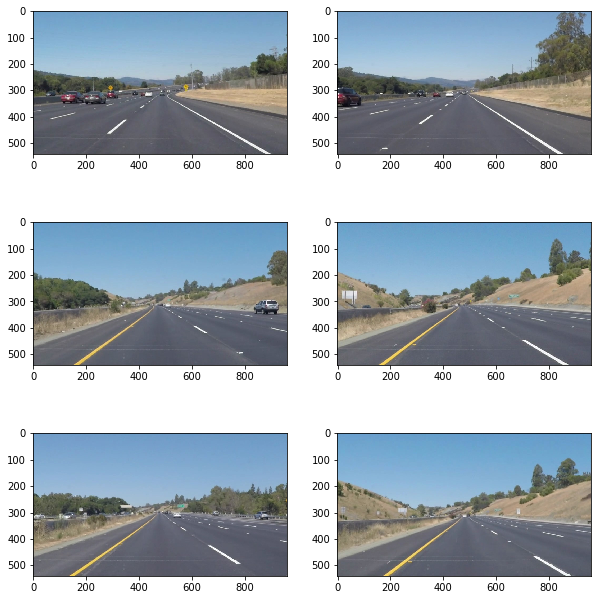

In [22]:
disp_images(test_images)

## 1. Color Selection 

As the first step of image processing we do a simple color selection. To identify the lane lines accurately the only significant colors are the different shades of **yellow** and **white** .

we use HSL ( Hue,Saturation and Lightness) representation of RGB color map. This representation rearranges the geometry of RGB into cylindrical co-ordinate system opposed to the cartesian system representation of RGB system. This is a popular technique to isolate a particular shade of pixels from an image.

### Process
- Convert the image from RGB to HLS using `cv2.cvtColor`
- create two masks one for extracting white pixels and the other for extracting yellow pixels
- combine the two masks
- superimpose the mask on the converted image


In [23]:
def filter_image(img):
    ''' Function to filter only white and yellow pixels from the image'''
    
    hls_image = cv2.cvtColor(img,cv2.COLOR_RGB2HLS);
    #White filter
    white_lower = np.uint8([0,200,0]);
    white_upper = np.uint8([255,255,255]);
    white_mask = cv2.inRange(hls_image,white_lower,white_upper);
    
    #Yellow filter
    yellow_lower = np.uint8([10,0,100]);
    yellow_upper = np.uint8([40,255,255]);
    yellow_mask = cv2.inRange(hls_image,yellow_lower,yellow_upper);
    
    # combine the masks
    msk = cv2.bitwise_or(white_mask,yellow_mask);
    final_img = cv2.bitwise_and(img,img,mask = msk)
    return final_img

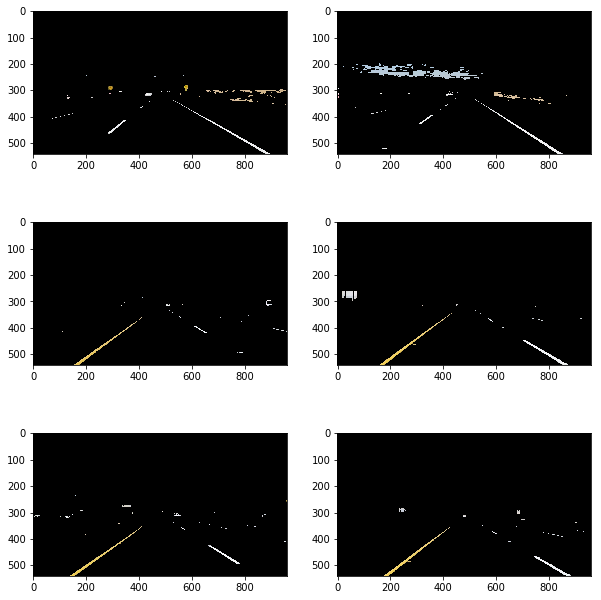

In [24]:
filtered_imgs = [filter_image(img) for img in test_images]
disp_images(filtered_imgs)

## Gray scaling

Next we convert the filtered images into gray scale images, in order better assist in edge detection

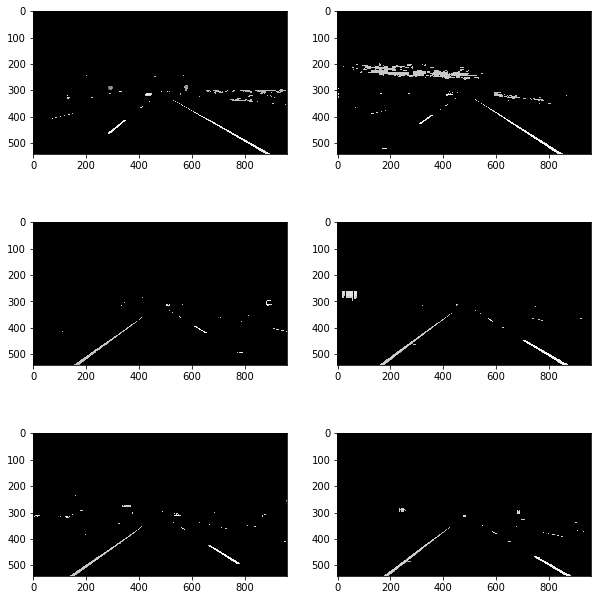

In [25]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
gray_imgs = [grayscale(img) for img in filtered_imgs]
disp_images(gray_imgs,'gray')    

## Gaussian Smoothing

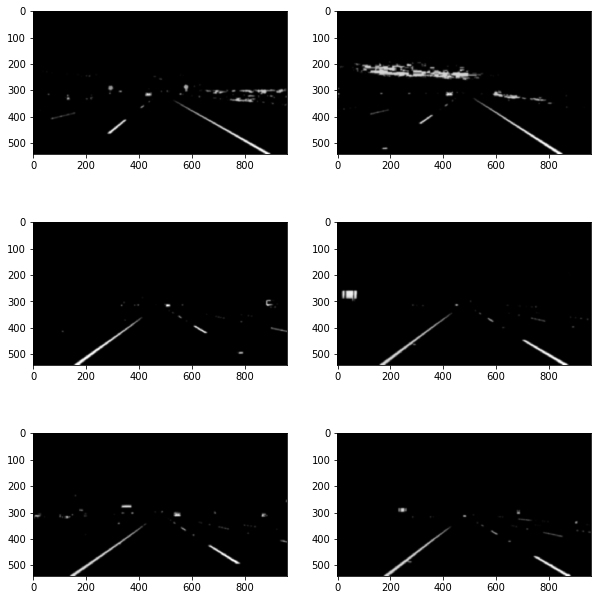

In [26]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
kernelSize = 15;
gauss_imgs = [gaussian_blur(img,kernelSize) for img in gray_imgs]
disp_images(gauss_imgs,'gray')

## Canny Edge Detection

we use `cv2.Canny` to detect the canny edges in the image

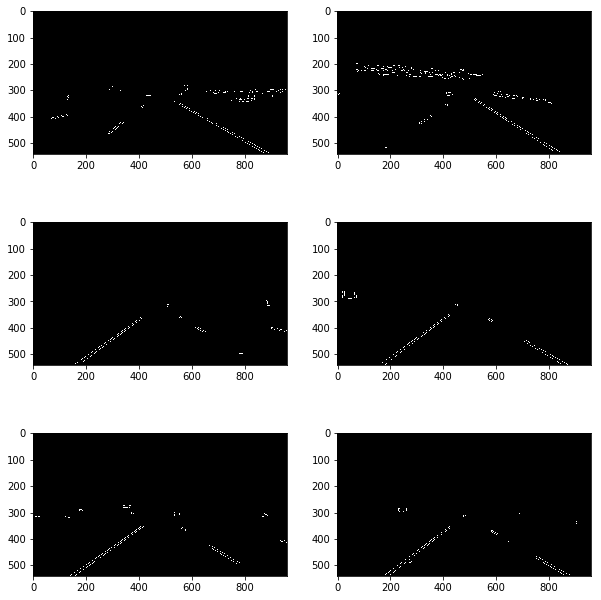

In [27]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
# Canny edge Parameters
low_threshold = 50
high_threshold = 150
edges_imgs = [canny(img,low_threshold,high_threshold) for img in gauss_imgs]
disp_images(edges_imgs,'gray')


## Region of Interest

We apply another image mask to extract only the pixels in the region of interest. Region of interest is a polyon area which contains the most significant information relating to the lanes and the road. We do this to avoid unnecessay detection of lines in the surroudings. Based on the camera position the lanes always fall within a certain polygon region.

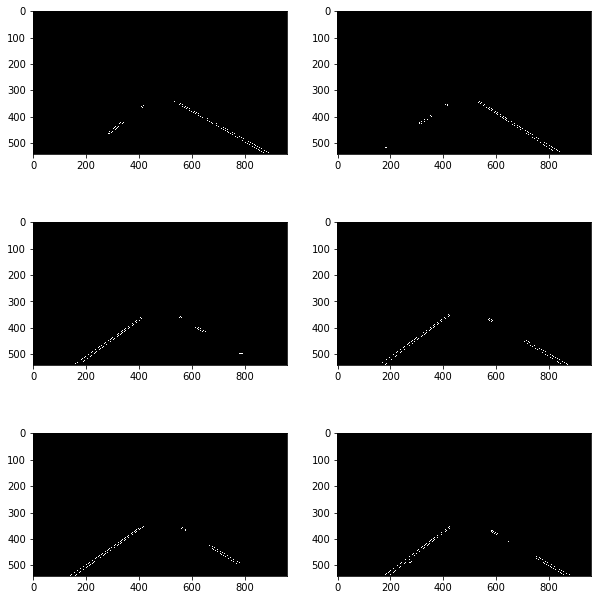

In [28]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = np.array([[(75,550),(430,340),(550,340),(950,550)]], dtype = np.int32)
ROI_imgs = [region_of_interest(img,vertices) for img in edges_imgs];
disp_images(ROI_imgs,'gray')

## Hough Transform
 Finally we perform haugh transform on the extracted image to identify the vertical lines (lanes) and we execute the `draw_lines` function to connect the disjoint lane lines.
 
 After identfying the lane lines we superimpose the identified lane lines on top of the original images to display and asses the accuracy of the lane detection.

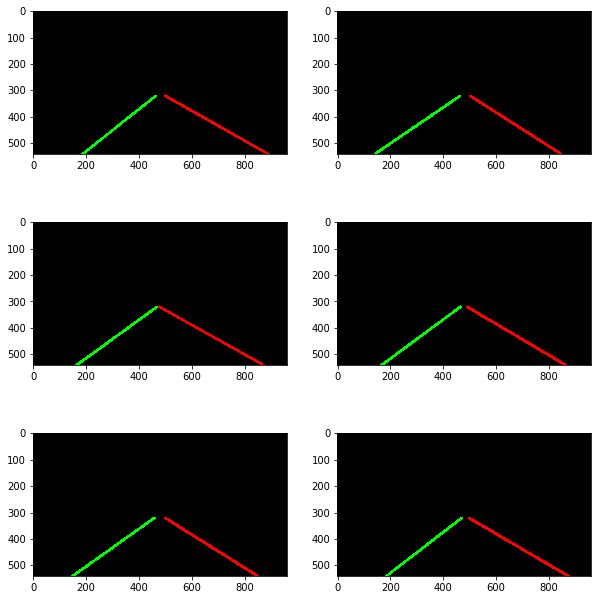

In [29]:
import math

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_points =[];
    left_points = [];
    left_slopes = [];
    right_slopes = [];
    color2 = [0, 255, 0];
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2-x1 ==0:
                # Ignore horizontal lines
                continue
            m= (y2-y1)/(x2-x1);
            if m >0 :
                right_points.append([x1,y1]);
                right_points.append([x2,y2]);
                right_slopes.append(m);
            else:
                left_points.append([x1,y1]);
                left_points.append([x2,y2]);
                left_slopes.append(m);    
                
    if len(right_points)>0:
        rp = np.array(right_points);
        rx = rp[:,0]; ry = rp[:,1]; A = np.vstack([rx,np.ones(len(rx))]).T;
        rm,rc = np.linalg.lstsq(A,ry)[0];
        rystart = img.shape[0];
        ryend = 320;
        rxstart = int((rystart -rc)/rm);
        rxend = min(int((ryend -rc)/rm),820);
        cv2.line(img, (rxstart, rystart), (rxend, ryend), color, thickness)
        
    if len(left_points)>0:
        lp = np.array(left_points);
        lx = lp[:,0]; ly = lp[:,1]; A = np.vstack([lx,np.ones(len(lx))]).T;
        lm,lc = np.linalg.lstsq(A,ly)[0];
        lystart = img.shape[0];
        lyend = 320;
        lxstart = int((lystart -lc)/lm);
        lxend = min(int((lyend -lc)/lm),820);
        cv2.line(img, (lxstart, lystart), (lxend, lyend), color2, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def PipeLine(img):
    """
    'img' is the initial image input. This function carries out the entire pipeline of 
    processing functions to identify the lane lines and returns the weighted image with
    the lane lines superimposed on the initial image.
    """
    
    # RGB to Grayscale
    img = filter_image(img);
    gray = grayscale(img);
    
    # Gaussian Smooting
    kernel_size = 15;
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
    
    # Canny edge Parameters
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray,low_threshold,high_threshold)
    
    # Region of interest
    vertices = np.array([[(75,550),(430,340),(550,340),(950,550)]], dtype = np.int32)
    masked_edges = region_of_interest(edges,vertices);
    #plt.imshow(masked_edges)
    '''# masked edges image
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    # Polygon mask
    imshape = image.shape
    vertices = np.array([[(75,550),(430,340),(550,340),(950,550)]], dtype = np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges,mask)
    region_of_interest()'''
    # Hough Transform
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 20
    max_line_gap = 30
    line_image = np.copy(masked_edges)*0
    lines_img = hough_lines(masked_edges,rho,theta,threshold, min_line_length, max_line_gap)

    
    # Weighted Image
    return_img = weighted_img(lines_img,img);    
    return return_img


# Hough Transform
rho = 1
theta = np.pi/180
threshold = 20
min_line_length = 20
max_line_gap = 30
lines_imgs = [hough_lines(img,rho,theta,threshold, min_line_length, max_line_gap) for img in ROI_imgs];
disp_images(lines_imgs,'gray')

    
    # Weighted Image
    #return_img = weighted_img(lines_img,img); 

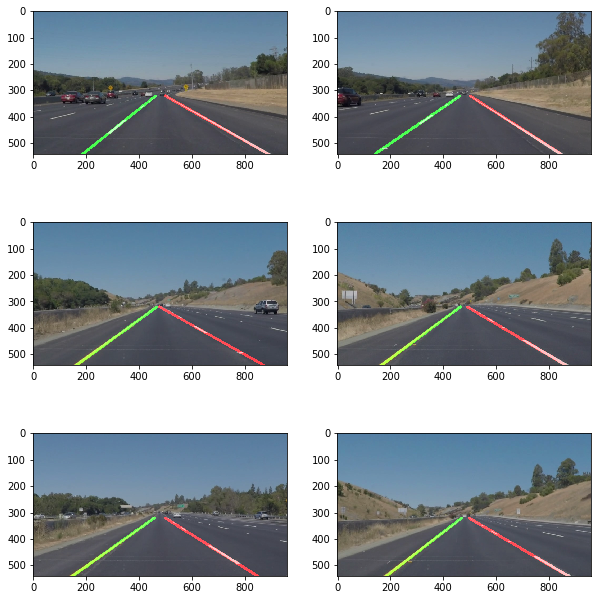

In [30]:
finalImgs = [weighted_img(img,init_img) for img,init_img in zip(lines_imgs,test_images)]
disp_images(finalImgs)

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML

In [32]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
     # RGB to Grayscale
    init_img = img;
    img = filter_image(img);
    gray = grayscale(img);
    
    # Gaussian Smooting
    blur_gray = cv2.GaussianBlur(gray,(kernelSize, kernelSize), 0)
    
    # Canny edge Parameters
    edges = canny(blur_gray,low_threshold,high_threshold)
    
    # Region of interest
    masked_edges = region_of_interest(edges,vertices);
    
    # Hough Transform
    lines_img = hough_lines(masked_edges,rho,theta,threshold, min_line_length, max_line_gap)
    
    # Weighted Image
    return_img = weighted_img(lines_img,init_img);    
    return return_img

In [35]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/challenge.mp4")
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
clip3 = VideoFileClip("test_videos/challenge.mp4")


In [36]:
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
yellow_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!

In [37]:
%time white_clip.write_videofile(white_output, audio=False)
%time yellow_clip.write_videofile(white_output, audio=False)
%time challenge_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:04<00:00, 45.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.33 s
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:15<00:00, 45.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 15.5 s
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:10<00:00, 23.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11.5 s
